In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay
np.random.seed(9000)

### Data Partitioning for Model Training and Testing

- We load the cleaned and labeled dataset (`labeled_desc_post_eda.csv`) and remove any rows with missing values to ensure data integrity.
- The dataset is then split into training and testing sets using an 80/20 split, ensuring that 80% of the data is used for training the model, and 20% is reserved for testing its performance.
- **`train_test_split`** is used with a fixed random seed (`random_state=9000`) to ensure reproducibility of the results.


In [107]:
#Create data partitions
data = pd.read_csv(f'labeled_desc_post_eda.csv', encoding='utf-8')
data = data.dropna()

X_train, X_test, y_train, y_test = train_test_split(data['text'], data['out'], test_size=0.2, random_state=9000)

### TF-IDF Vectorization of Text Data

- We use **`CountVectorizer`** to convert the text data into a matrix of token counts (bag-of-words model).
- The vectorizer is fit to the training data (`X_train`), and then both the training and test sets are transformed into their respective count matrices.
- This step converts the raw text into a numerical representation, which is essential for feeding the data into machine learning models.
- The shape of the resulting matrices indicates the number of documents and the size of the vocabulary.

The output shows the shape of the transformed training and test datasets.


In [25]:
tfidf_count_vect = CountVectorizer()
X_train_tfidf_counts = tfidf_count_vect.fit_transform(X_train)
X_test_tfidf_counts = tfidf_count_vect.transform(X_test)
X_train_tfidf_counts.shape,X_test_tfidf_counts.shape

((617, 1911), (155, 1911))

### TF-IDF Vectorization of Text Data

- We use **`CountVectorizer`** to convert the text data into a matrix of term counts, focusing on **Term Frequency (TF)**.
- Since the goal is to identify whether a given text contains qualifications (skills, libraries, tools, etc.), **IDF** is not applied, as frequent terms like "Python," "Data Analysis," or "Machine Learning" are important and should not be downweighted.
- This approach ensures that relevant, commonly occurring terms are not penalized, as they play a crucial role in determining the presence of qualifications in the text.
- The text data is transformed into numerical representations, which will be used in further stages of model training and testing.



In [26]:
tfidf_freq_transformer = TfidfTransformer(use_idf=False)
X_train_freq = tfidf_freq_transformer.fit_transform(X_train_tfidf_counts)
X_test_freq = tfidf_freq_transformer.transform(X_test_tfidf_counts)

### Naive Bayes Model for Classification

We start by using a **Multinomial Naive Bayes** model, which is known for its simplicity and ability to generalize well. Naive Bayes is a high bias, low variance model, meaning:
- It has a lower tendency to overfit the training data.
- It is a good baseline model, especially for text classification tasks like this, where the features (terms in the document) are independent of one another.


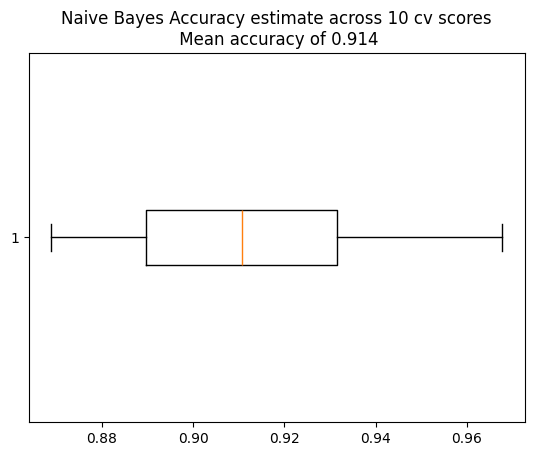

In [100]:
naive = MultinomialNB()
scores = cross_val_score(naive,X_train_freq,y_train,cv = 10)
naive_classifier = naive.fit(X_train_freq,y_train)
nbc_acc = np.round(np.mean(scores),3)

blue_diamond = dict(markerfacecolor='b', marker='D')
plt.boxplot(scores,vert=False,flierprops=blue_diamond)
plt.title(f"Naive Bayes Accuracy estimate across 10 cv scores\n Mean accuracy of {nbc_acc}")
plt.show()


### Observation: Naive Bayes Performance

The Naive Bayes model achieved a **mean accuracy of 91.4%** across 10-fold cross-validation, demonstrating that it generalizes well to the training data. The box plot also shows relatively low variance in the cross-validation scores, further indicating that the model is not overfitting and is a strong baseline to start with.

While the Naive Bayes model performed well, we will now experiment with a **Support Vector Machine (SVM)** classifier to see if we can achieve further improvement in training accuracy. 

### Support Vector Machine with Polynomial Kernel

We now apply a **Support Vector Machine (SVM)** classifier with a **polynomial kernel** to see if we can improve the model’s performance.


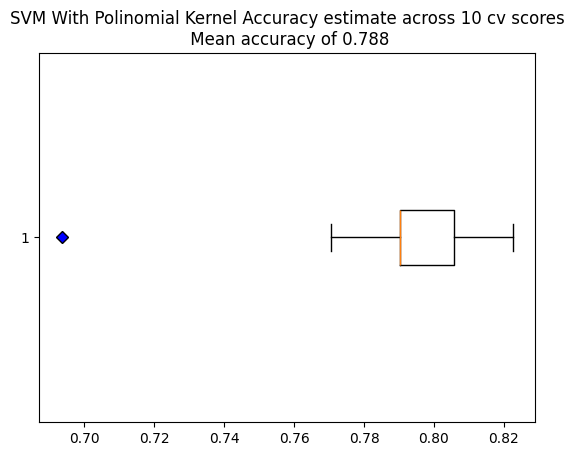

In [111]:
vector_machine = svm.SVC(kernel='poly', probability=True)
vector_classifier = vector_machine.fit(X_train_freq,y_train)
scores = cross_val_score(vector_machine,X_train_freq,y_train,cv = 10)
svm_p_acc = np.round(np.mean(scores),3)

plt.boxplot(scores,vert=False,flierprops=blue_diamond)
plt.title(f"SVM With Polinomial Kernel Accuracy estimate across 10 cv scores\n Mean accuracy of {svm_p_acc}")
plt.show()

### Observation: SVM with Polynomial Kernel - Lower Than Expected Results

The **SVM with a polynomial kernel** achieved a mean accuracy of **78.8%**, which is lower than the Naive Bayes classifier's accuracy of 91.4%. Several factors may explain this underperformance:

#### Possible Reasons for Lower Performance:
1. **Overfitting to Training Data**:
   - The polynomial kernel is more complex and may have overfit the training data, capturing noise instead of generalizable patterns.

2. **Inappropriate Kernel Choice**:
   - The polynomial kernel might not be suitable for the structure of this data. Simpler or more linear decision boundaries might be more effective for this problem.

3. **High Dimensionality**:
   - The text data after vectorization likely has high dimensionality. Polynomial kernels may struggle in such high-dimensional feature spaces, where linear models often perform better.

4. **Polynomial Degree**:
   - The default polynomial degree is 3, which may not match the patterns in the data, leading to lower performance.



### Next: Linear SVM

Given the results, we will now try a **linear kernel SVM**. Linear kernels are often more appropriate for high-dimensional spaces like text data, where simpler, linear decision boundaries may yield better results.


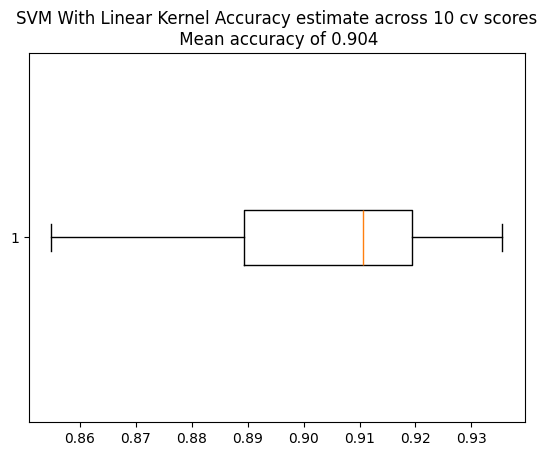

In [102]:
vector_machine_lnr = svm.SVC(kernel='linear', probability=True)
vector_classifier_lnr = vector_machine_lnr.fit(X_train_freq,y_train)
scores = cross_val_score(vector_machine_lnr,X_train_freq,y_train,cv = 10)
svm_l_acc = np.round(np.mean(scores),3)

plt.boxplot(scores,vert=False,flierprops=blue_diamond)
plt.title(f"SVM With Linear Kernel Accuracy estimate across 10 cv scores\n Mean accuracy of {svm_l_acc}")
plt.show()

### Observation: SVM with Linear Kernel - Results

The **SVM with a linear kernel** achieved a mean accuracy of **90.4%**, which is:
- **Better than the polynomial kernel SVM** (78.8%).
- **Slightly lower than Naive Bayes** (91.4%).

This suggests that the linear kernel is more appropriate for this dataset, likely due to the high dimensionality of the text data, where linear decision boundaries perform well. However, Naive Bayes still performs slightly better overall.

### Next: SVM with RBF Kernel

Given that the linear SVM performed reasonably well, we will now experiment with an **RBF (Radial Basis Function) kernel** to see if we can further improve the classification performance.


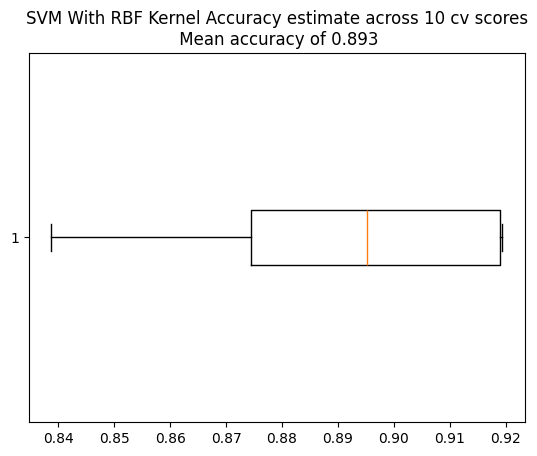

In [112]:
vector_machine_rbf = svm.SVC(kernel='rbf', probability=True)
vector_classifier_rbf = vector_machine_rbf.fit(X_train_freq,y_train)
scores = cross_val_score(vector_machine_rbf,X_train_freq,y_train,cv = 10)
svm_rbf_acc = np.round(np.mean(scores),3)

plt.boxplot(scores,vert=False,flierprops=blue_diamond)
plt.title(f"SVM With RBF Kernel Accuracy estimate across 10 cv scores\n Mean accuracy of {svm_rbf_acc}")
plt.show()

### Observation: SVM with RBF Kernel - Results

The **SVM with RBF kernel** achieved a mean accuracy of **89.3%**, which is:
- **Higher than the polynomial kernel SVM** (78.8%).
- **Lower than the linear kernel SVM** (90.4%) and **Naive Bayes** (91.4%).

The RBF kernel, which is more flexible and can handle non-linear relationships in the data, performs slightly worse than the linear SVM in this case. This suggests that the linear decision boundary is more effective for this dataset, likely due to the high dimensionality and relatively simpler relationships between the features.

---

### Comparison of Confusion Matrices for Different Classifiers

In this step, we will visualize the performance of each model by plotting confusion matrices. This allows us to see how well each model is predicting the **Qualification** and **Description** classes.

#### Confusion Matrix Overview:
- The confusion matrix provides a detailed breakdown of **True Positives (TP)**, **True Negatives (TN)**, **False Positives (FP)**, and **False Negatives (FN)**.
- This visualization will help us evaluate where the models are performing well and where they are making classification errors.

#### Models Included:
1. **Naive Bayes** - The best-performing model so far with the highest accuracy.
2. **Polynomial Kernel SVM** - The lowest-performing SVM, used for comparison.
3. **RBF Kernel SVM** - Performed slightly worse than the linear kernel.
4. **Linear Kernel SVM** - A strong performer, second to Naive Bayes.

Each confusion matrix is plotted side-by-side for easy comparison, allowing us to see the classification patterns across all models.


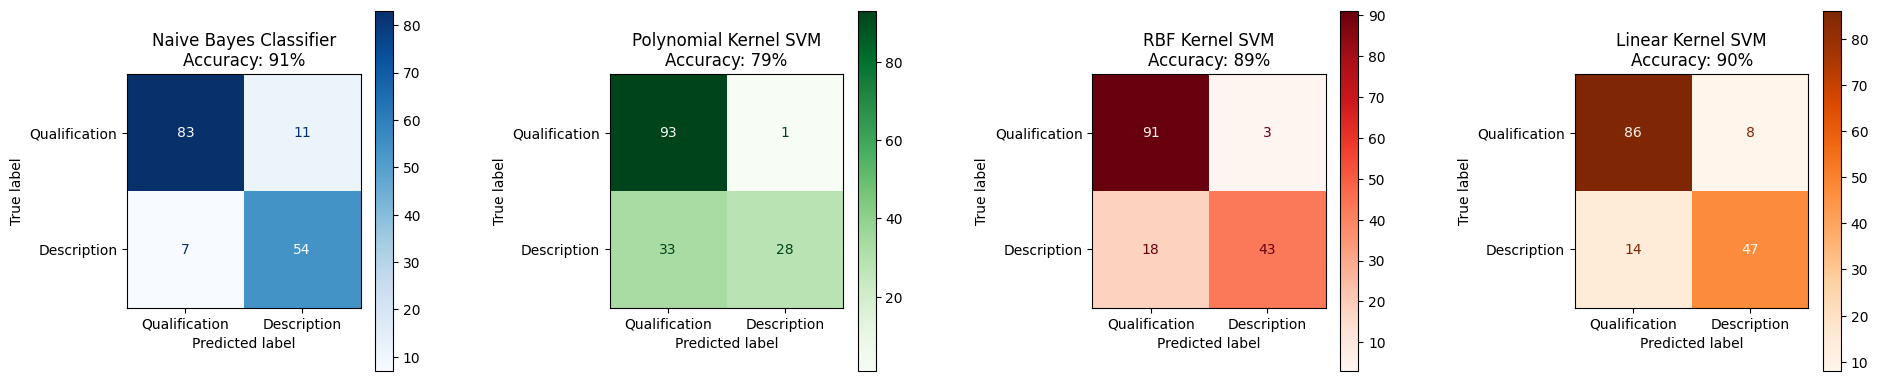

In [110]:
# Create subplots for four confusion matrices
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))  # Increase figure size

# Naive Bayes Classifier
ConfusionMatrixDisplay.from_estimator(naive_classifier, X_test_freq, y_test, 
                                      display_labels=['Qualification', 'Description'], 
                                      cmap=plt.cm.Blues, ax=ax1)
ax1.set_title(f"Naive Bayes Classifier\nAccuracy: {nbc_acc * 100:.0f}%")

# Polynomial Kernel SVM
ConfusionMatrixDisplay.from_estimator(vector_classifier, X_test_freq, y_test, 
                                      display_labels=['Qualification', 'Description'], 
                                      cmap=plt.cm.Greens, ax=ax2)
ax2.set_title(f"Polynomial Kernel SVM\nAccuracy: {svm_p_acc * 100:.0f}%")

# RBF Kernel SVM
ConfusionMatrixDisplay.from_estimator(vector_classifier_rbf, X_test_freq, y_test, 
                                      display_labels=['Qualification', 'Description'], 
                                      cmap=plt.cm.Reds, ax=ax3)
ax3.set_title(f"RBF Kernel SVM\nAccuracy: {svm_rbf_acc * 100:.0f}%")

# Linear Kernel SVM
ConfusionMatrixDisplay.from_estimator(vector_classifier_lnr, X_test_freq, y_test, 
                                      display_labels=['Qualification', 'Description'], 
                                      cmap=plt.cm.Oranges, ax=ax4)
ax4.set_title(f"Linear Kernel SVM\nAccuracy: {svm_l_acc * 100:.0f}%")

# Adjust layout
plt.subplots_adjust(wspace=0.5)  # Increase space between subplots
fig.tight_layout(pad=5.0)  # Adjust padding around the figure
plt.show()


### ROC Curve and AUROC Comparison

After analyzing the confusion matrices, it's important to further assess the performance of each model using **ROC curves** and **Area Under the ROC Curve (AUROC)**. The ROC curve helps us visualize the trade-off between the **True Positive Rate (Sensitivity)** and the **False Positive Rate**, giving us a better understanding of how well each model distinguishes between the two classes.

In this next step, we will:
- Calculate the **predicted probabilities** for the positive class (qualification) for each classifier.
- Plot the **ROC curves** for each model and compute the **AUROC** values, which summarize the model's performance. A higher AUROC value indicates a better-performing classifier.
- Compare the ROC curves of **Naive Bayes**, **Polynomial SVM**, **RBF SVM**, and **Linear SVM** to see how well they differentiate between qualifications and descriptions.

This will allow us to visualize each model's performance beyond accuracy and confusion matrices.


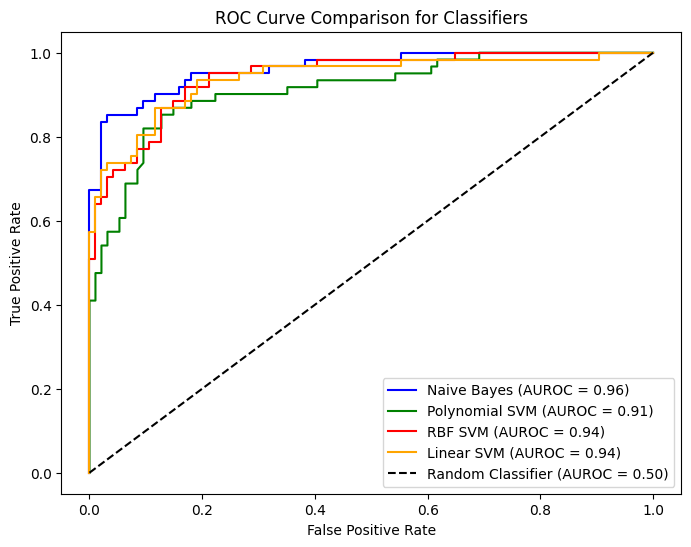

In [109]:
# Calculate the predicted probabilities for the positive class (label 1)
y_pred_nb = naive_classifier.predict_proba(X_test_freq)[:, 1]  # Naive Bayes
y_pred_poly = vector_classifier.predict_proba(X_test_freq)[:, 1]  # Polynomial SVM
y_pred_rbf = vector_classifier_rbf.predict_proba(X_test_freq)[:, 1]  # RBF SVM
y_pred_linear = vector_classifier_lnr.predict_proba(X_test_freq)[:, 1]  # Linear SVM

# Calculate the ROC curve and AUROC for each classifier
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb)
fpr_poly, tpr_poly, _ = roc_curve(y_test, y_pred_poly)
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, y_pred_rbf)
fpr_linear, tpr_linear, _ = roc_curve(y_test, y_pred_linear)

roc_auc_nb = roc_auc_score(y_test, y_pred_nb)
roc_auc_poly = roc_auc_score(y_test, y_pred_poly)
roc_auc_rbf = roc_auc_score(y_test, y_pred_rbf)
roc_auc_linear = roc_auc_score(y_test, y_pred_linear)

# Plot ROC curves with a smaller figure size
plt.figure(figsize=(8, 6))  # Reduce the size to 8x6 inches

# Naive Bayes ROC curve
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUROC = {roc_auc_nb:.2f})', color='blue')

# Polynomial SVM ROC curve
plt.plot(fpr_poly, tpr_poly, label=f'Polynomial SVM (AUROC = {roc_auc_poly:.2f})', color='green')

# RBF Kernel SVM ROC curve
plt.plot(fpr_rbf, tpr_rbf, label=f'RBF SVM (AUROC = {roc_auc_rbf:.2f})', color='red')

# Linear Kernel SVM ROC curve
plt.plot(fpr_linear, tpr_linear, label=f'Linear SVM (AUROC = {roc_auc_linear:.2f})', color='orange')

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUROC = 0.50)')

# Labels and title
plt.title('ROC Curve Comparison for Classifiers')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the plot
plt.show()


### Model Comparison: Confusion Matrices and ROC Curves

#### Confusion Matrices
The confusion matrices for the four classifiers show their classification performance in terms of **True Positives (TP)**, **True Negatives (TN)**, **False Positives (FP)**, and **False Negatives (FN)**:

1. **Naive Bayes Classifier (Accuracy: 91%)**
   - Strong performance with a good balance between both classes. 
   - Slightly fewer false negatives (7) compared to other models, making it a strong performer for detecting qualifications.

2. **Polynomial Kernel SVM (Accuracy: 79%)**
   - Struggled with classification, particularly for the "Description" class. 
   - Has a higher number of false negatives (33) compared to others, indicating difficulty in accurately predicting qualifications.

3. **RBF Kernel SVM (Accuracy: 89%)**
   - Better performance than the polynomial kernel, but still slightly behind the Naive Bayes and Linear SVM. 
   - It has fewer false negatives (18) but a slightly higher number of false positives (3) compared to the Naive Bayes.

4. **Linear Kernel SVM (Accuracy: 90%)**
   - Performed well, with a balance close to Naive Bayes. 
   - Slightly higher false negatives (14) than Naive Bayes, but overall strong classification performance.

#### ROC Curves and AUROC
The **ROC curves** provide a visual comparison of the models' true positive rate (sensitivity) against their false positive rate:

- **Naive Bayes**: Highest AUROC of **0.96**, making it the best-performing model in terms of both accuracy and its ability to distinguish between the two classes.
- **Polynomial SVM**: Lower AUROC of **0.91**, confirming that it struggles with classification accuracy.
- **RBF SVM**: AUROC of **0.94**, a strong performer and close to the linear SVM.
- **Linear SVM**: AUROC of **0.94**, performing similarly to the RBF SVM but with slightly better overall accuracy.

### Summary
- **Naive Bayes** emerges as the strongest model overall, with the highest accuracy and AUROC.
- **Linear SVM** performs well, offering competitive results close to Naive Bayes, making it a strong alternative.
- **RBF SVM** performs respectably but doesn't outperform Naive Bayes or Linear SVM.
- **Polynomial SVM** underperforms significantly compared to the other models, struggling with accurate classification.

### Conclusion:
Given the results, **Naive Bayes** and **Linear SVM** are the best models for this task, offering both high accuracy and a strong ability to distinguish between qualifications and descriptions. 

**For now, we will proceed with the Naive Bayes classifier** as our main model. However, to explore the potential for further improvements, we will also examine the performance of a **Long Short-Term Memory (LSTM) Neural Network** in the next steps (next notebook).



In [114]:
import joblib

# Save the trained Naive Bayes Classifier
joblib.dump(naive_classifier, 'nb_classifier.pkl')

# Save the CountVectorizer for future text transformations
joblib.dump(tfidf_count_vect, 'tfidf_count_vect.pkl')

# Save the TF-IDF frequency transformer for future use
joblib.dump(tfidf_freq_transformer, 'tfidf_freq_transformer.pkl')

['tfidf_freq_transformer.pkl']